In [1]:
%matplotlib inline

from glnem import GLNEM
from glnem.datasets import load_trees

## Check Assumption 2 [rank($\bar{X}$) = $p$]

In [4]:
from glnem.network_utils import node_averaged_rank

# there are 3 covariates plus an intercept, so p = 4
Y, X = load_trees(include_diag=True)

node_averaged_rank(X)

4

## Fit a Poisson GLNEM ($d = 10$)

In [3]:
# we fit the various GLNEMs on the sub-diagonal entries
Y, X = load_trees(include_diag=False)

pois_glnem = GLNEM(family='poisson', link='log', n_features=10, random_state=23)
pois_glnem.sample(Y, X, n_warmup=7500, n_samples=15000)

sample: 100%|█████████████████████████████████████| 22500/22500 [03:41<00:00, 101.41it/s, 63 steps of size 6.59e-02. acc. prob=0.92]


In [4]:
pois_glnem.print_summary()

WAIC: 3957.760

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         X1     -0.41      0.03     -0.41     -0.47     -0.37     71.06      1.01
         X2     -1.63      0.13     -1.63     -1.84     -1.42    204.76      1.00
         X3      0.04      0.02      0.04      0.01      0.08    187.60      1.00
  intercept      2.74      0.25      2.71      2.36      3.18     67.97      1.01
  lambda[0]     26.41      1.53     26.38     23.83     28.87    318.61      1.00
  lambda[1]     14.50      1.82     14.63     11.41     17.39    138.39      1.01
  lambda[2]     -0.91      3.04      0.00      0.00     -0.00    127.04      1.01
  lambda[3]     -0.45      2.19      0.00     -0.00     -0.00    354.76      1.00
  lambda[4]     -0.44      2.14      0.00      0.00     -0.00    351.96      1.00
  lambda[5]     -0.24      1.61      0.00     -0.00      0.00   1241.78      1.00
  lambda[6]     -0.15      1.28      0.00      0.00     -0.00   2026.08      1.00


## Diagnostic Plots (Figure S17)

<IPython.core.display.Javascript object>


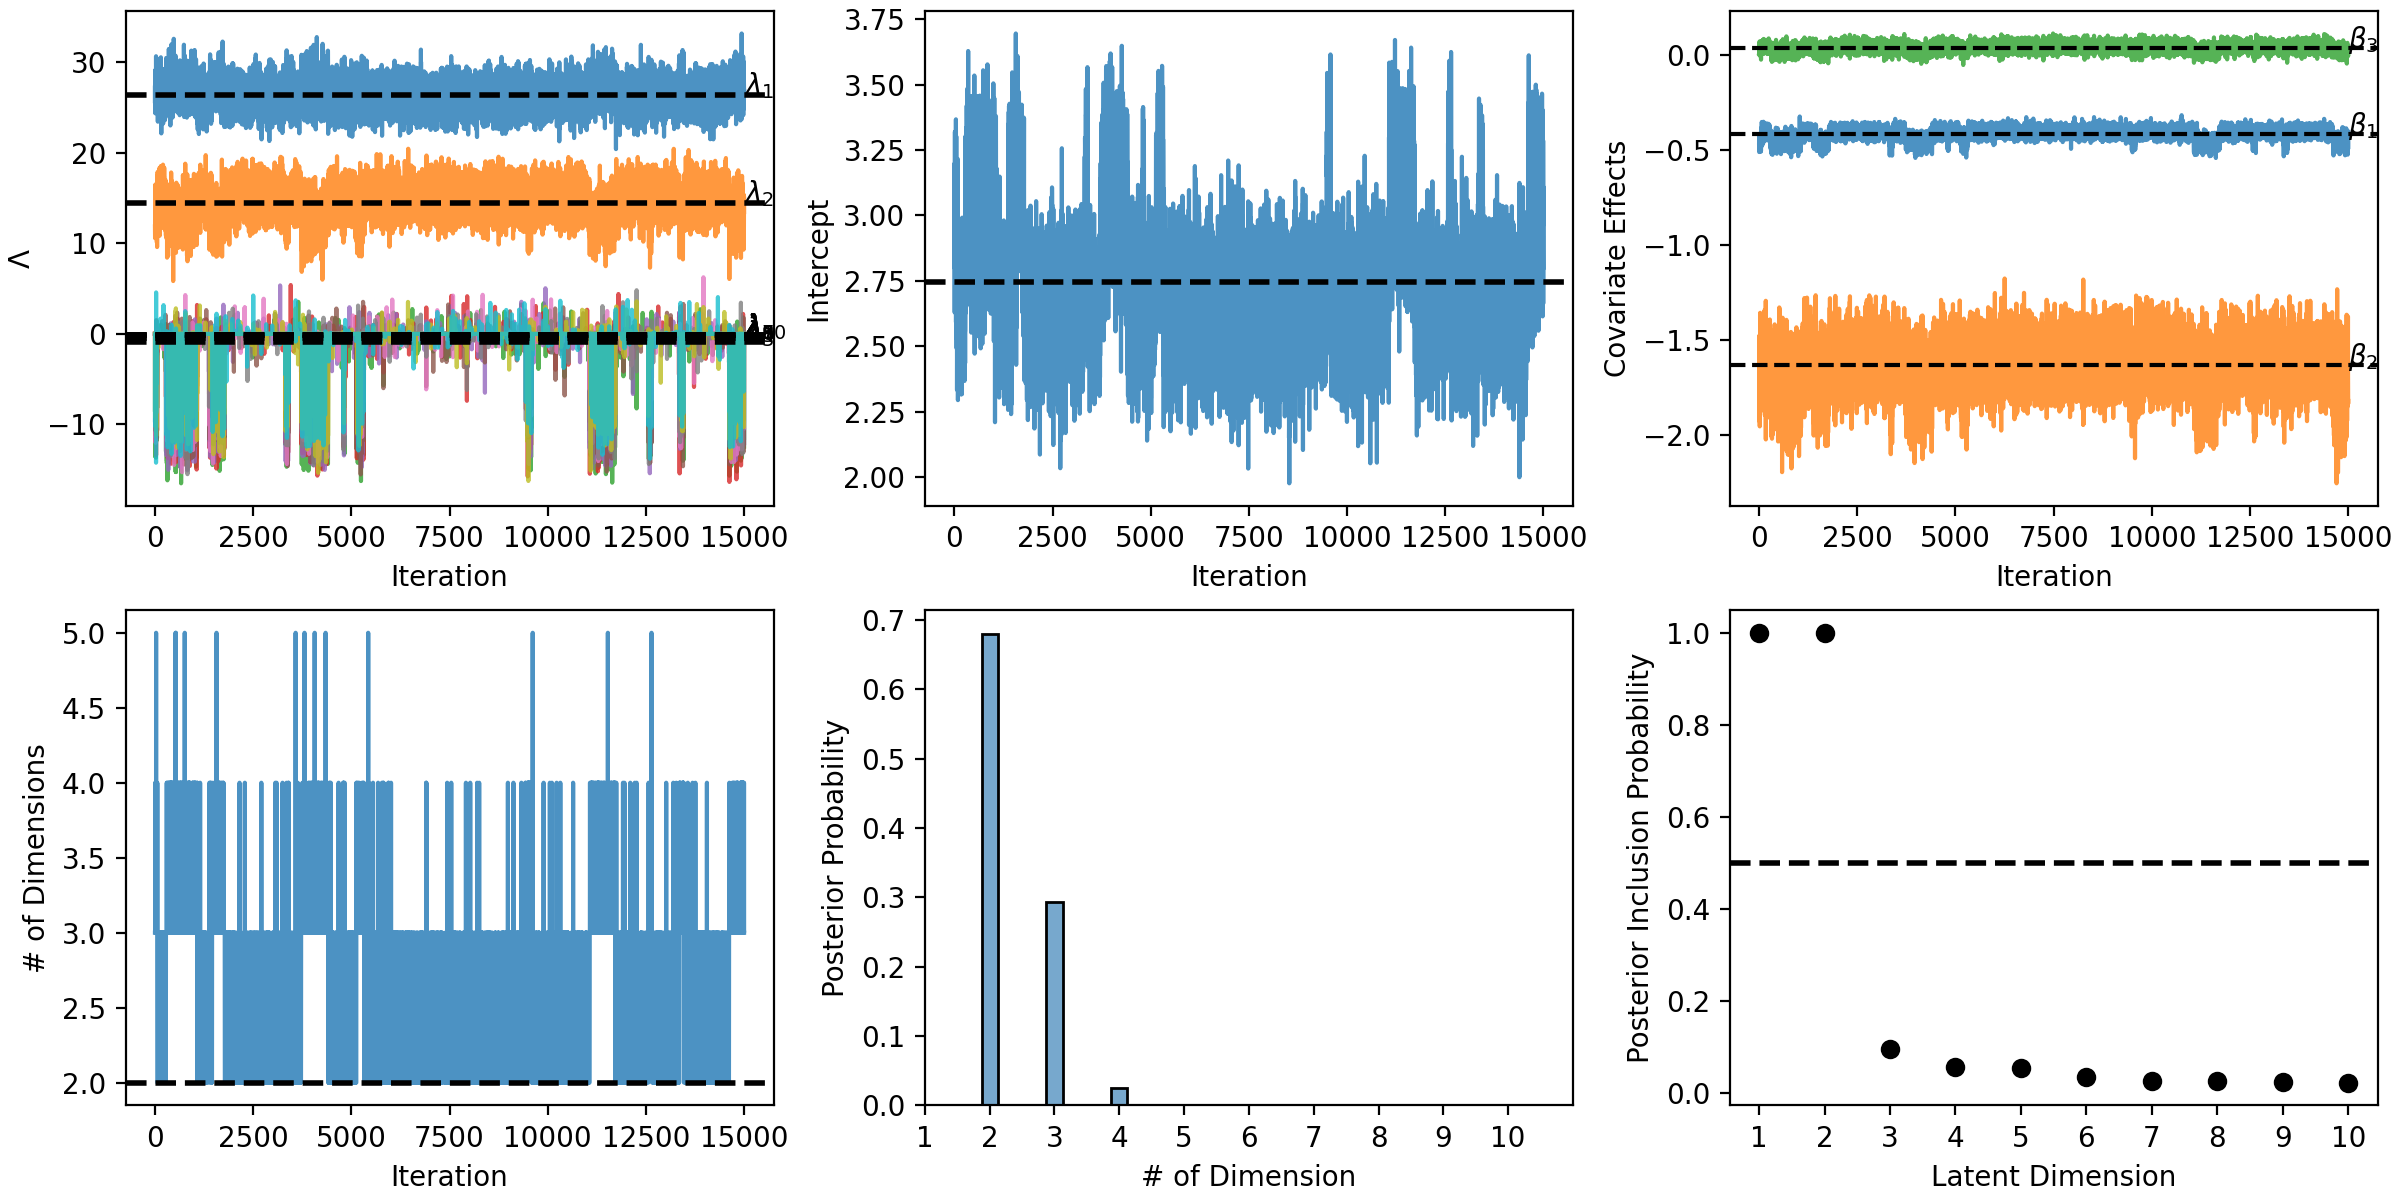

In [15]:
pois_glnem.plot(Y_obs=Y, include_diagnostics=False, figsize=(12,6))

## Fit a Negative Binomial GLNEM ($d = 10$)

In [15]:
negbin_glnem = GLNEM(family='negbinom', link='log',n_features=10, random_state=23)
negbin_glnem.sample(Y, X, n_warmup=7500, n_samples=15000)

sample: 100%|██████████████████████████████████████| 22500/22500 [13:18<00:00, 28.16it/s, 63 steps of size 8.69e-02. acc. prob=0.93]


In [11]:
negbin_glnem.print_summary(proba=0.95)

WAIC: 3808.103

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
          X1     -0.49      0.02     -0.49     -0.54     -0.44  33859.77      1.00
          X2     -1.81      0.17     -1.81     -2.13     -1.45  31675.51      1.00
          X3      0.04      0.04      0.04     -0.03      0.11  30597.90      1.00
  dispersion      0.53      0.06      0.53      0.42      0.65  36131.64      1.00
   intercept      3.21      0.24      3.21      2.74      3.69  28004.43      1.00
   lambda[0]     30.64      2.42     30.59     26.01     35.44  13930.76      1.00
   lambda[1]      0.00      0.16      0.00      0.00      0.00  14797.42      1.00
   lambda[2]     -0.00      0.15      0.00     -0.00     -0.00  14637.59      1.00
   lambda[3]     -0.00      0.15      0.00     -0.00     -0.00  15460.05      1.00
   lambda[4]      0.00      0.12      0.00      0.00     -0.00  14770.92      1.00
   lambda[5]     -0.00      0.16      0.00      0.00      0.00  14316.6

## Diagnostic Plots (Figure S18)

<IPython.core.display.Javascript object>


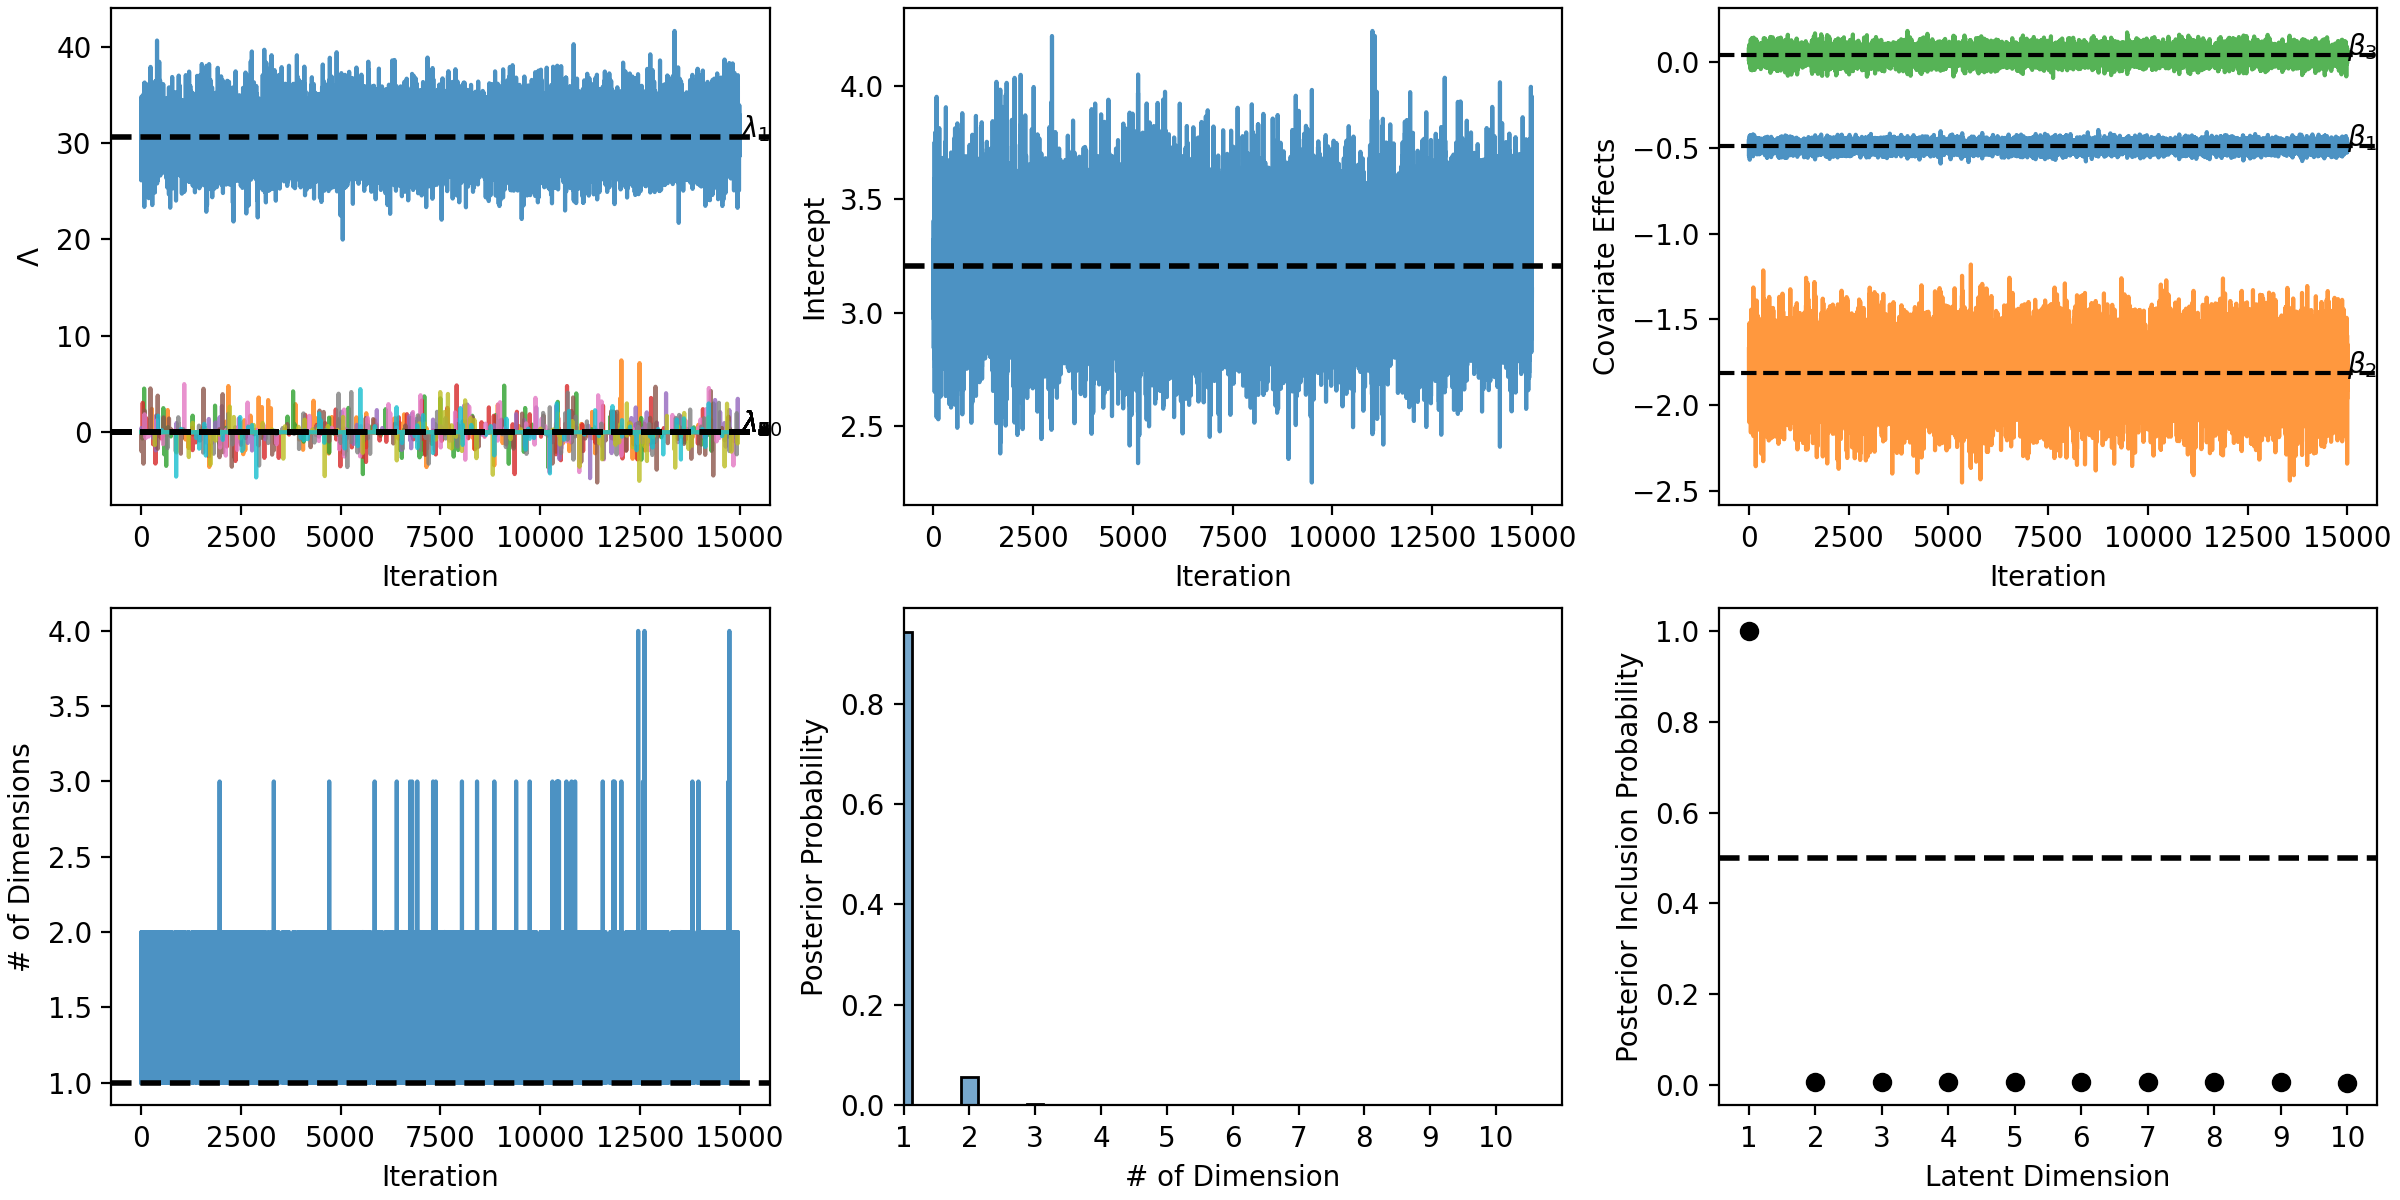

In [17]:
negbin_glnem.plot(Y_obs=Y, include_diagnostics=False, figsize=(12, 6))

## Negative Binomial Latent Space (Figure S6)

<IPython.core.display.Javascript object>


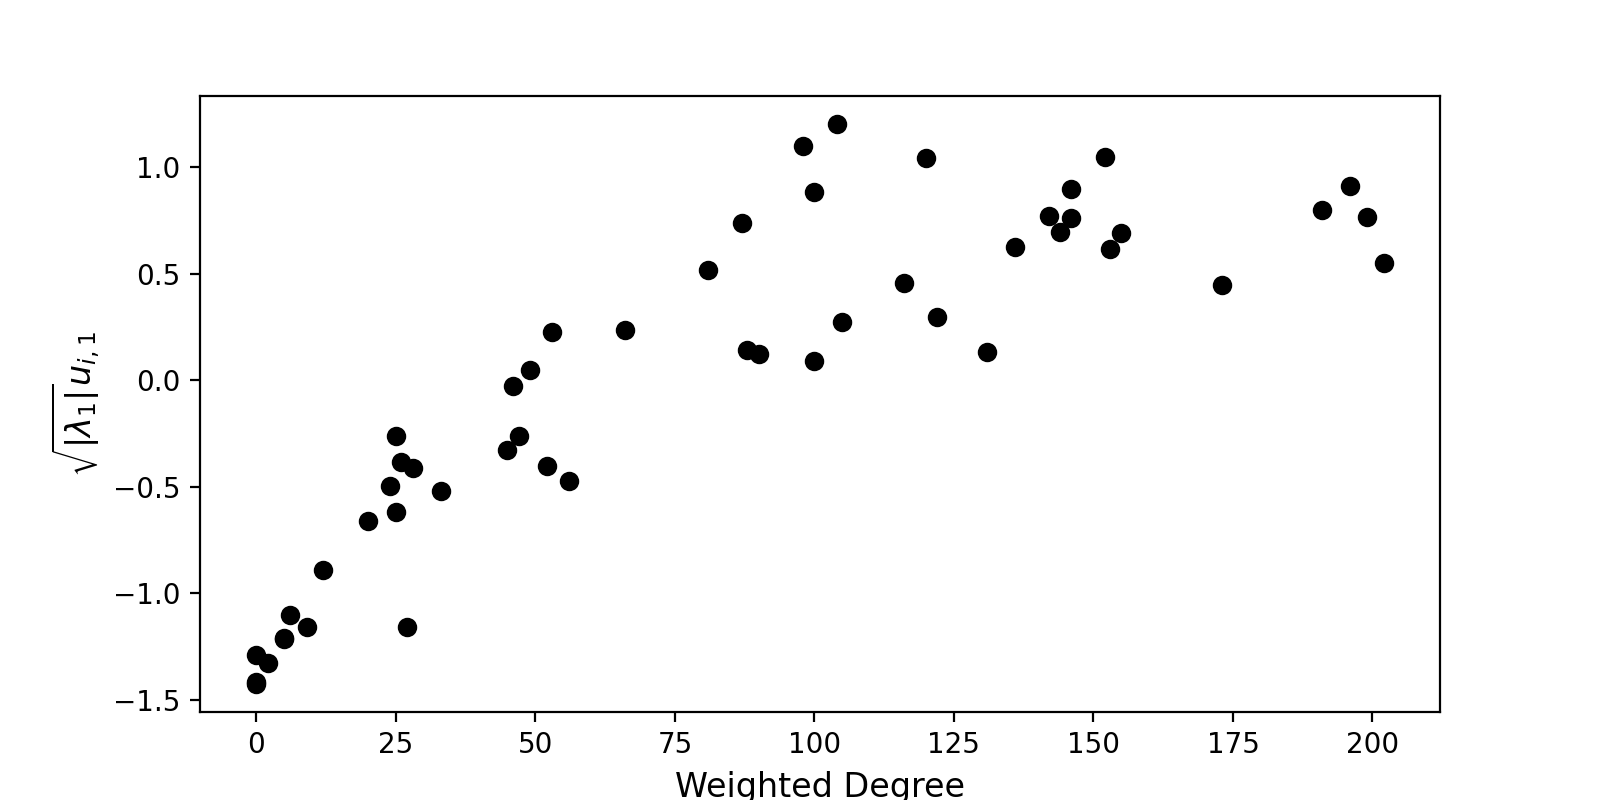

In [9]:
fig, ax = plt.subplots(figsize=(8,4))

d = Y.sum(axis=1)
u = negbin_glnem.samples_['U'].mean(axis=0)[:, 0]
ax.scatter(d, 
           np.sqrt(negbin_glnem.lambda_[0]) * negbin_glnem.U_[:, 0],
           c='k')
ax.set_xlabel('Weighted Degree', fontsize=12)
ax.set_ylabel(r"$\sqrt{|\lambda_1|} u_{i,1}$", fontsize=12)

## Coefficient Comparison Plot (Figure S5)

<IPython.core.display.Javascript object>


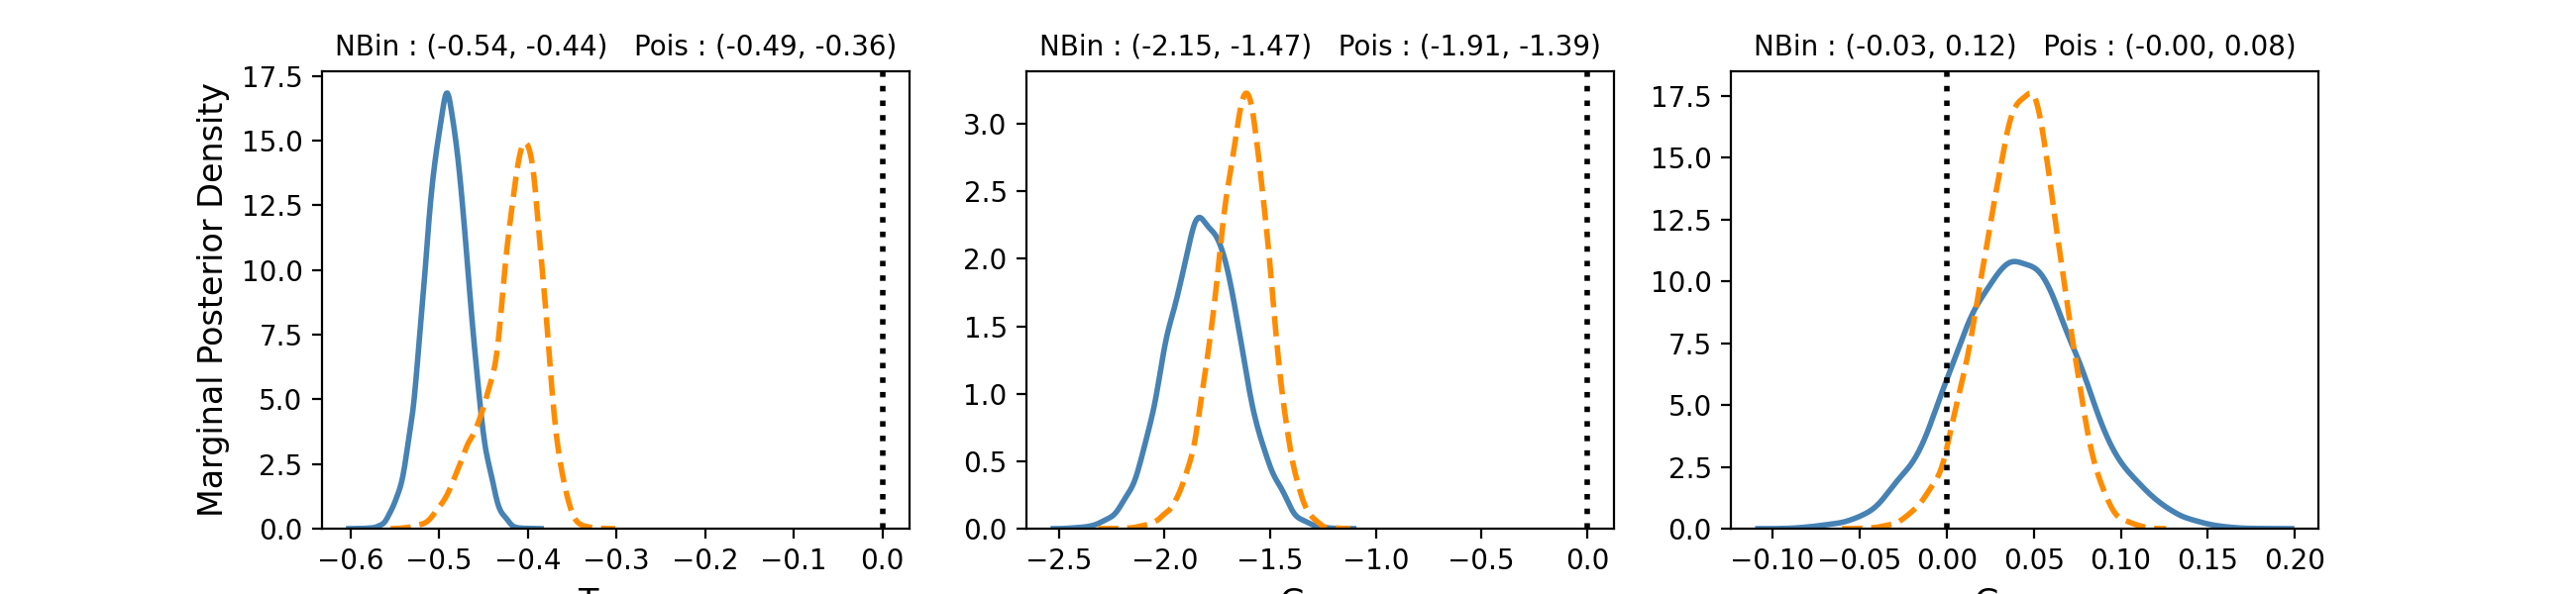

In [10]:
import seaborn as sns

fig, ax = plt.subplots(ncols=3, figsize=(13, 3))

labels = {'X1': r"Tax$_{ij}$", 
          'X2': r'Geo$_{ij}$', 
          'X3': r'Gene$_{ij}$'}
fam = ['NBin', 'Pois']
xtext = [0.4, 0.45, 0.53]

colors = ['steelblue', 'darkorange']
linestyle = ['solid', 'dashed']
for k, var in enumerate(['X1', 'X2', 'X3']):
    title = ''
    for i, glnem in enumerate([negbin_glnem, pois_glnem]):
        interval = list(np.quantile(
            glnem.samples_[var], q=[0.025, 0.975]))
        mean = glnem.samples_[var].mean()
        sns.kdeplot(glnem.samples_[var], c=colors[i], ax=ax[k],
                    linestyle=linestyle[i],
                    label=fam[i], lw=2)
        
        title += f"{fam[i]} : ({interval[0]:.2f}, {interval[1]:.2f})"
        if i == 0:
            title += '   '
        
        
    if k == 1:    
        ax[k].legend(bbox_to_anchor=(0.5, 1.33), loc='upper center',
                    fontsize=12, ncol=2)
        
    ax[k].axvline(0, c='k', linestyle='dotted', lw=2)
    ax[k].set_xlabel(labels[var], fontsize=12)
    ax[k].set_ylabel('Marginal Posterior Density', fontsize=12)
    ax[k].set_title(title, fontsize=10)
    if k > 0:
        ax[k].set_ylabel('')

# Sensitivity to Truncation Level $d$

## Poisson GLNEM (d = 6)

In [31]:
pois_glnem_d6 = GLNEM(family='poisson', link='log', n_features=6, random_state=23)
pois_glnem_d6.sample(Y, X, n_warmup=7500, n_samples=15000)

sample: 100%|█████████████████████████████████████| 22500/22500 [02:15<00:00, 165.70it/s, 63 steps of size 7.24e-02. acc. prob=0.93]


## Poisson GLNEM (d = 12)

In [35]:
pois_glnem_d12 = GLNEM(family='poisson', link='log', n_features=12, random_state=23)
pois_glnem_d12.sample(Y, X, n_warmup=7500, n_samples=15000)

sample: 100%|██████████████████████████████████████| 22500/22500 [04:46<00:00, 78.48it/s, 63 steps of size 6.42e-02. acc. prob=0.92]


## Negative Binomial GLNEM (d = 6)

In [22]:
negbin_glnem_d6 = GLNEM(family='negbinom', link='log',n_features=6, random_state=23)
negbin_glnem_d6.sample(Y, X, n_warmup=7500, n_samples=15000)

sample: 100%|██████████████████████████████████████| 22500/22500 [12:35<00:00, 29.78it/s, 63 steps of size 9.53e-02. acc. prob=0.93]


## Negative Binomial (d = 12)

In [27]:
negbin_glnem_d12 = GLNEM(family='negbinom', link='log',n_features=12, random_state=23)
negbin_glnem_d12.sample(Y, X, n_warmup=7500, n_samples=15000)

sample: 100%|██████████████████████████████████████| 22500/22500 [14:51<00:00, 25.23it/s, 63 steps of size 8.70e-02. acc. prob=0.93]


## Negative Binomial Dimension Posterior Comparison (Figure S13)

<IPython.core.display.Javascript object>


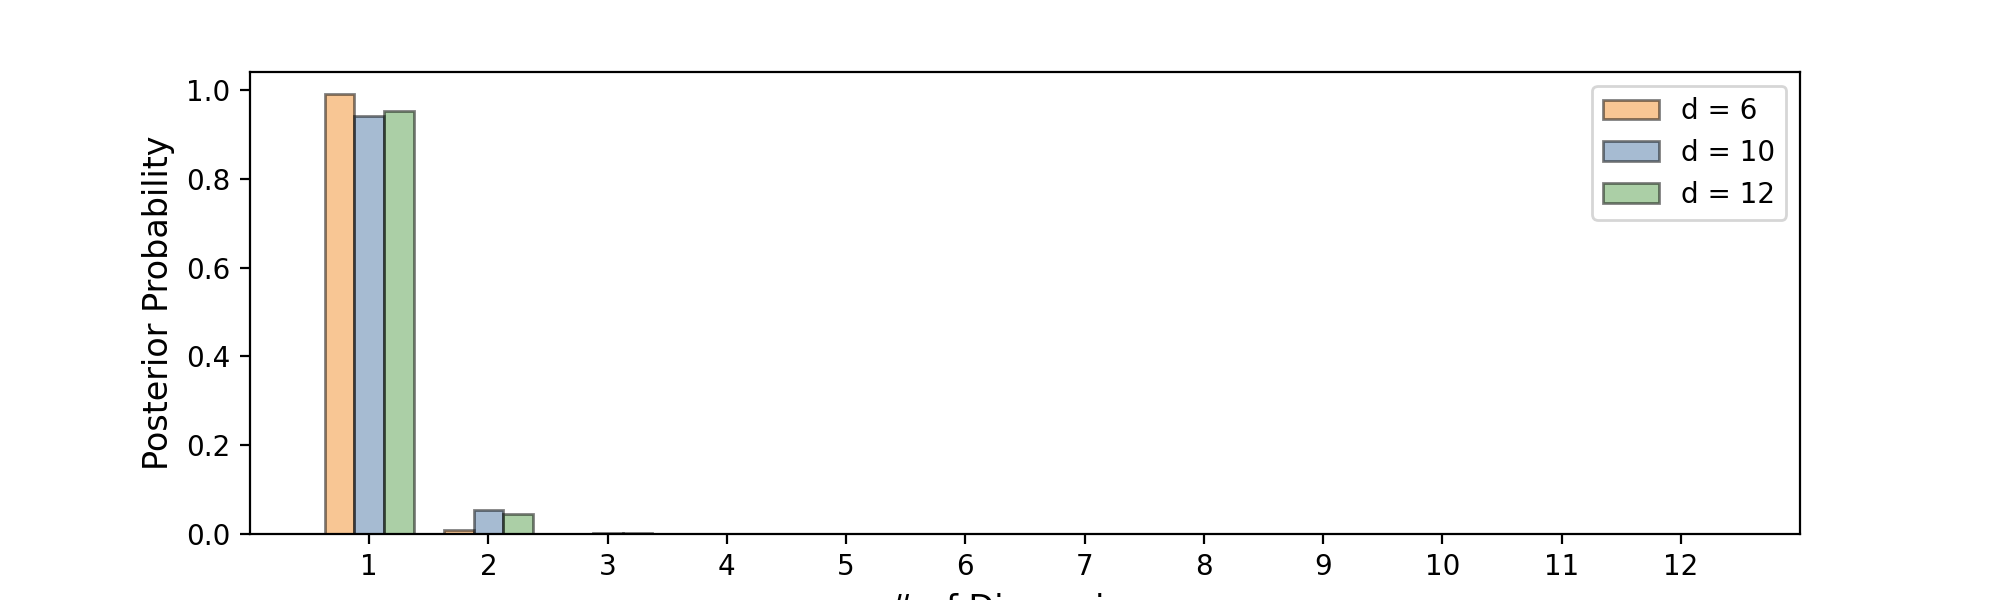

In [76]:
fig, ax = plt.subplots(figsize=(10,3))

count_d10 = np.bincount(negbin_glnem.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d12 = np.bincount(negbin_glnem_d12.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d6 = np.bincount(negbin_glnem_d6.samples_['z'].sum(axis=1), minlength=12)[1:]

ax.bar(np.arange(1, 12)-0.25, count_d6/count_d6.sum(), 
       width=0.25,alpha=0.5, color='#f28e2b', edgecolor='k', label='d = 6')
ax.bar(np.arange(1, 12), count_d10/count_d10.sum(), 
       color='#4e79a7', width=0.25, alpha=0.5, edgecolor='k', label='d = 10')
ax.bar(np.arange(1, 12)+0.25, count_d12/count_d12.sum(), 
       color='#59a14f', width=0.25, alpha=0.5, edgecolor='k', label='d = 12')
ax.set_xlim(0, 13)
ax.set_xticks(np.arange(1, 13))
ax.set_xlabel('# of Dimensions', fontsize=12)
ax.set_ylabel('Posterior Probability', fontsize=12)

ax.legend()

## Poisson Posterior Comparison (Figure S11)

<IPython.core.display.Javascript object>


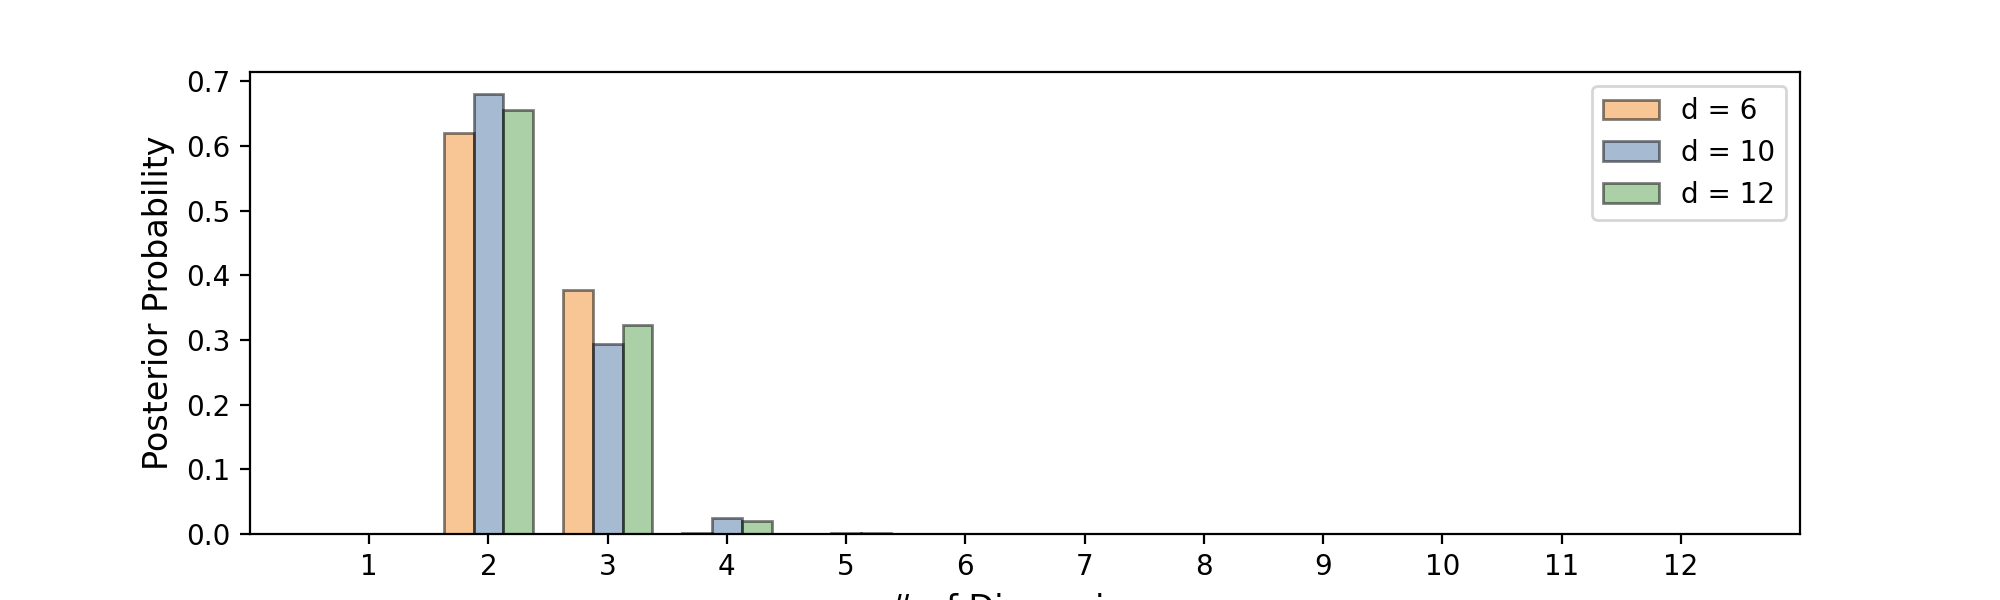

In [70]:
fig, ax = plt.subplots(figsize=(10,3))
count_d10 = np.bincount(pois_glnem.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d12 = np.bincount(pois_glnem_d12.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d6 = np.bincount(pois_glnem_d6.samples_['z'].sum(axis=1), minlength=12)[1:]
ax.bar(np.arange(1, 12)-0.25, count_d6/count_d6.sum(), 
       width=0.25,alpha=0.5, color='#f28e2b', edgecolor='k', label='d = 6')
ax.bar(np.arange(1, 12), count_d10/count_d10.sum(), 
       color='#4e79a7', width=0.25, alpha=0.5, edgecolor='k', label='d = 10')
ax.bar(np.arange(1, 12)+0.25, count_d12/count_d12.sum(), 
       color='#59a14f', width=0.25, alpha=0.5, edgecolor='k', label='d = 12')
ax.set_xlim(0, 13)
ax.set_xticks(np.arange(1, 13))
ax.set_xlabel('# of Dimensions', fontsize=12)
ax.set_ylabel('Posterior Probability', fontsize=12)

ax.legend()

## Poisson Node-Averaged Effects Comparison (Figure S10)

<IPython.core.display.Javascript object>


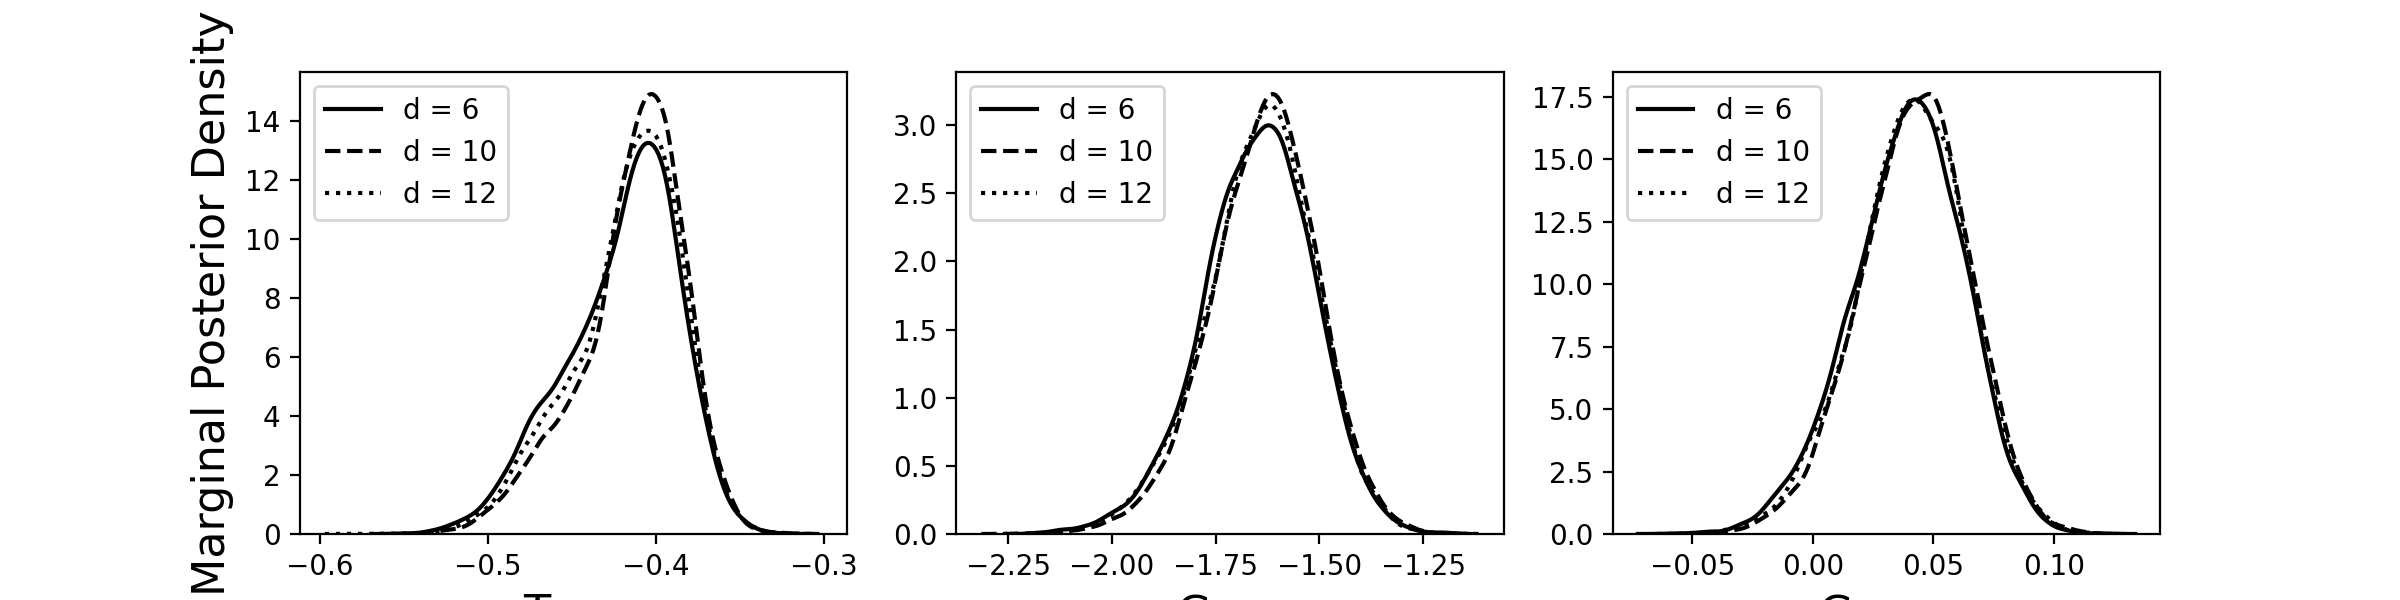

In [77]:
labels = {'X1': r"Tax$_{ij}$", 
          'X2': r'Geo$_{ij}$', 
          'X3': r'Gene$_{ij}$'}

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

for k in range(3):
    sns.kdeplot(pois_d6.samples_[f'X{k+1}'], c='k', linestyle='-', ax=ax[k], label='d = 6')
    sns.kdeplot(pois_d10.samples_[f'X{k+1}'], c='k', linestyle='--', ax=ax[k], label='d = 10')
    sns.kdeplot(pois_d12.samples_[f'X{k+1}'], c='k', linestyle=':', ax=ax[k], label='d = 12')
    
    #ax[k].axvline(0, c='k', linestyle='dotted', lw=2)
    ax[k].set_xlabel(labels[f'X{k+1}'], fontsize=16)
    ax[k].set_ylabel('Marginal Posterior Density', fontsize=16)
    if k > 0:
        ax[k].set_ylabel('')
    ax[k].legend()

## Negative Binomial Node-Averaged Effects Comparison (Figure S12)

<IPython.core.display.Javascript object>


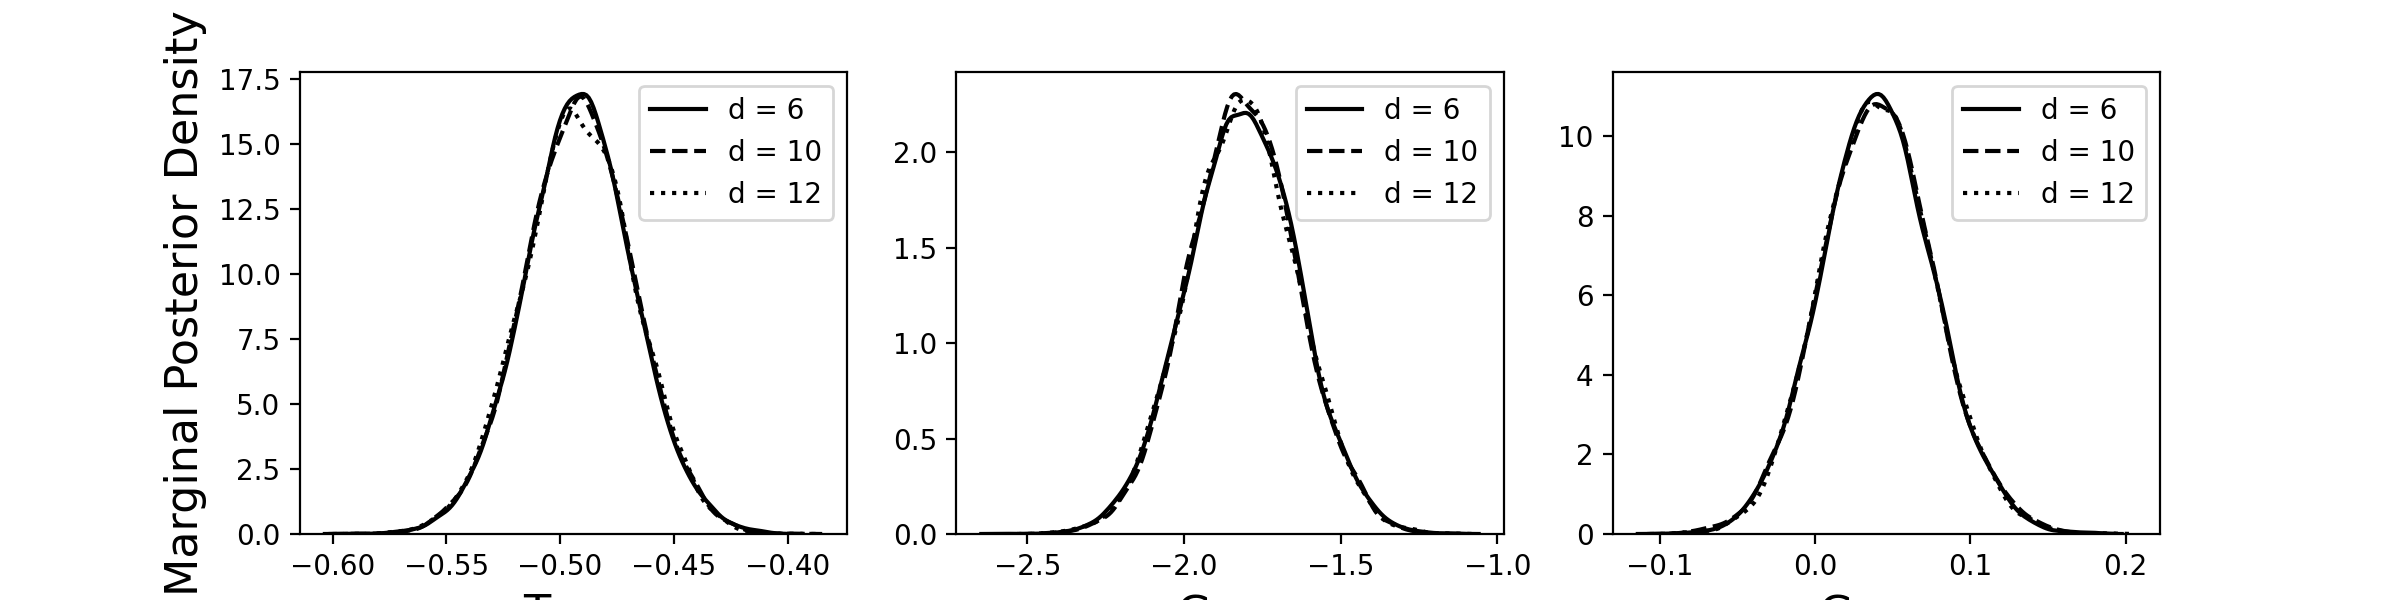

In [69]:
labels = {'X1': r"Tax$_{ij}$", 
          'X2': r'Geo$_{ij}$', 
          'X3': r'Gene$_{ij}$'}

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

for k in range(3):
    sns.kdeplot(negbin_d6.samples_[f'X{k+1}'], c='k', linestyle='-', ax=ax[k], label='d = 6')
    sns.kdeplot(negbin_d10.samples_[f'X{k+1}'], c='k', linestyle='--', ax=ax[k], label='d = 10')
    sns.kdeplot(negbin_d12.samples_[f'X{k+1}'], c='k', linestyle=':', ax=ax[k], label='d = 12')
    
    #ax[k].axvline(0, c='k', linestyle='dotted', lw=2)
    ax[k].set_xlabel(labels[f'X{k+1}'], fontsize=16)
    ax[k].set_ylabel('Marginal Posterior Density', fontsize=16)
    if k > 0:
        ax[k].set_ylabel('')
    ax[k].legend()